# **Анализ данных.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from os.path import isfile
import pickle
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

%matplotlib inline

sns.set_style(style='white')
sns.set_palette(sns.color_palette("Dark2"))

In [2]:
src_train = pd.read_csv('./data/train.csv')
src_test = pd.read_csv('./data/test.csv')

In [3]:
print(src_train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
print(src_test.isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
print(src_train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [6]:
print(src_test.columns.values)

['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


Пока понятно, что начать нужно с импутации. 

Объединю, для начала, два датасета. Чтобы можно было импутировать данные сразу в оба. 

In [7]:
src_df = pd.concat([src_train, src_test], ignore_index=True).reset_index()

In [8]:
print(src_df.isna().sum())

index             0
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


Разберемся с названиями столбцов и что это значит.
1. Survived - выжил человек или нет.
2. Pclass - класс каюты.
3. Name - имя.
4. Sex - пол.
5. Age - возраст.
6. SibSp - количество родственников второго порядка. Муж, жена, братья, сестры.
7. Parch - количество родственников первоко порядка. Мать, отец, ребенок.
8. Ticket - номер билета.
9. Fare - цена билета.
10. Cabin - каюта.
11. Embarked - порт посадки. C - Cherbourg. Q - Queenstown. S - Southampton.

Тут нужно понимать, что общество в те времена было сословным и патриархальным. Поэтому людей и спасали и лечили и всё остальное по сословному признаку.

Посмотрим на данные в разрезе взаимосвязей каждого из параметров и выживания.

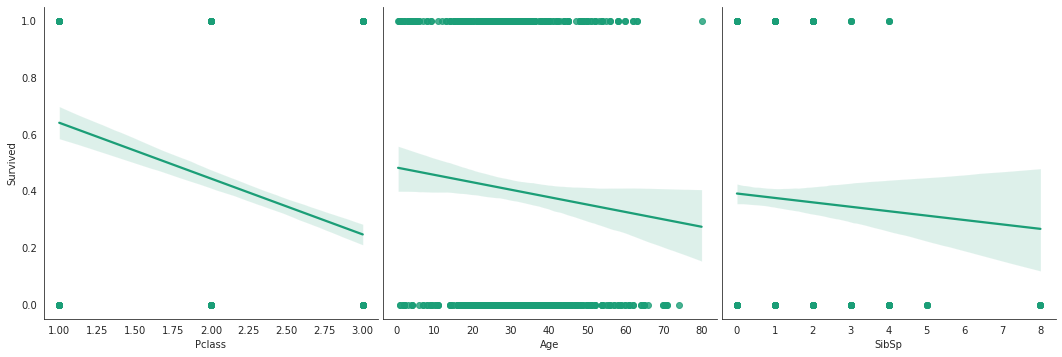

In [9]:
sns.pairplot(data=src_df, x_vars=['Pclass', 'Age', 'SibSp'], y_vars='Survived', height=5, aspect=1.0, kind='reg')
plt.show()

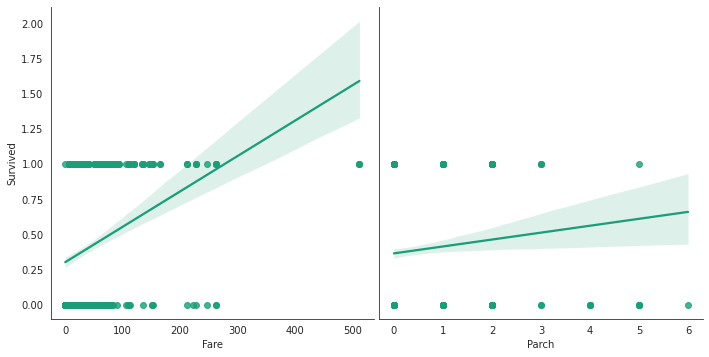

In [10]:
sns.pairplot(data=src_df, x_vars=['Fare', 'Parch'], y_vars='Survived', height=5, aspect=1.0, kind='reg')

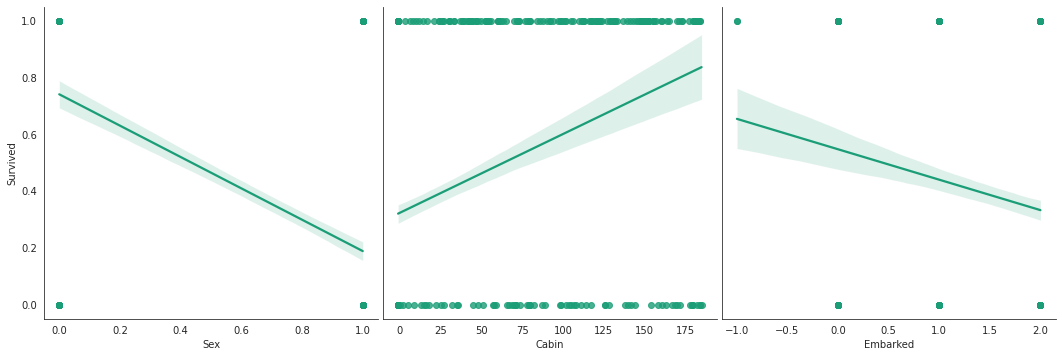

In [11]:
temp_df = src_df[['Sex', 'Cabin', 'Embarked']].astype('category').apply(lambda x: x.cat.codes)
temp_df['Survived'] = src_df['Survived']

sns.pairplot(data=temp_df, x_vars=['Sex', 'Cabin', 'Embarked'], y_vars='Survived', height=5, aspect=1.0, kind='reg')
plt.show()

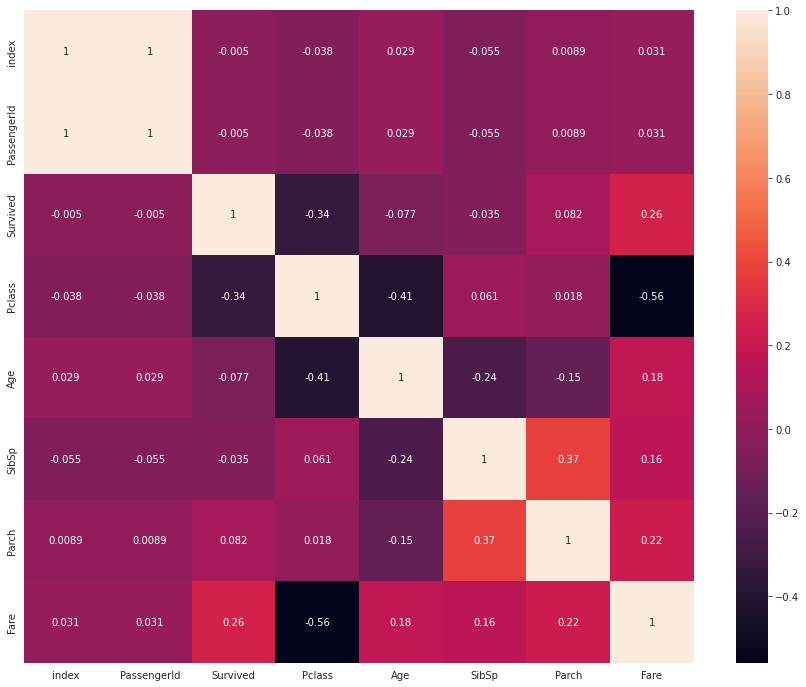

In [12]:
plt.figure(figsize = (15, 12))
sns.heatmap(src_df.corr(), annot=True)
plt.show()

Что тут предварительно можно сказать?
1. Как и следовало ожидать, класс каюты прямо, с хорошим доверительным интервалом, влияет на выживание.
2. Пол тоже имеет хорошую взаимосвязь с выживанием.
3. Каюта и порт посадки скорее всего связаны с классом. Скорее всего в двух каких-то портах село большее количество пассажиров определенных классов.
4. Наличие родственников отрицательно влияет на шанс выжить.
5. Чем ниже цена билета, тем ниже выживаемость.
6. Возростная группа примерно 15-30 имеет хороший доверительный тинтервал.
7. Особенно интересна взаимосвязь цены билета и выживаемости. У самых богатых, получается, шансов утонуть небыло?
<br>Всё логично. 

# **Обработка данных.**

Пропущенное значение посадки можно просто нагуглить. Тупо в каком порту эти люди сели.

In [13]:
src_df['Embarked'] = src_df['Embarked'].fillna('S')

К категориям пол и посадка можно смело применить LabelEncoding.

In [14]:
src_df['Sex'] = src_df['Sex'].map(lambda x: 0 if x == 'male' else 1)#.astype('category').cat.codes
src_df['Embarked'] = src_df['Embarked'].astype('category').cat.codes

Очевидно, что родственников первого и второго порядка можно объединить.

In [15]:
src_df['Family'] = src_df['SibSp'] + src_df['Parch']

Поскольку одно отсутствуещее значение цены билета принадлежит дядьке без родственников в третьем классе, присвоим ему среднее по третьему классу.

In [16]:
med_fare = src_df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

In [17]:
src_df['Fare'] = src_df['Fare'].fillna(med_fare)

Интересно, что есть нулевые цены билетов. Нужно взглянуть.

In [18]:
zero_price = src_df.loc[src_df['Fare'] == 0]
print(zero_price[['Pclass', 'Parch', 'SibSp']])

      Pclass  Parch  SibSp
179        3      0      0
263        1      0      0
271        3      0      0
277        2      0      0
302        3      0      0
413        2      0      0
466        2      0      0
481        2      0      0
597        3      0      0
633        1      0      0
674        2      0      0
732        2      0      0
806        1      0      0
815        1      0      0
822        1      0      0
1157       1      0      0
1263       1      0      0


Похоже, что это кто-то из гостей или команды, или что-то вроде. Поставлю среднее.

In [19]:
med_fare_1 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[1][0][0]
med_fare_2 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[2][0][0]
med_fare_3 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

print(med_fare_1, med_fare_2, med_fare_3)

33.5 13.0 7.8542


In [20]:
#src_df.loc[(src_df['Fare'] == 0) & (src_df['Pclass'] == 1)] = med_fare_1
#src_df.loc[(src_df['Fare'] == 0) & (src_df['Pclass'] == 2)] = med_fare_2
#src_df.loc[(src_df['Fare'] == 0) & (src_df['Pclass'] == 3)] = med_fare_3

In [21]:
zero_price = src_df.loc[src_df['Fare'] == 0]
print(zero_price[['Pclass', 'Parch', 'SibSp']])

      Pclass  Parch  SibSp
179        3      0      0
263        1      0      0
271        3      0      0
277        2      0      0
302        3      0      0
413        2      0      0
466        2      0      0
481        2      0      0
597        3      0      0
633        1      0      0
674        2      0      0
732        2      0      0
806        1      0      0
815        1      0      0
822        1      0      0
1157       1      0      0
1263       1      0      0


Не знаю как использовать имя и номер билета. Родственников первого и второго порядка я тоже выкину.

In [22]:
#src_df.drop(['SibSp', 'Parch', 'Ticket', 'Name'], inplace=True, axis=1)

Возраст. Тут сложно. Нужно посмотреть, что влияет на возраст.

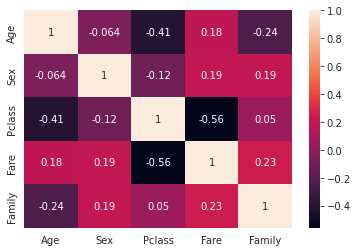

In [23]:
temp_df = src_df[['Age', 'Sex', 'Pclass', 'Fare', 'Family']]
sns.heatmap(temp_df.corr(), annot=True)
plt.show()

Пол не особо влияет. Возраст растет с классом. Семья, что не удивительно, тоже растет с возрастом. <br>
Попробую регрессию.

In [24]:
X = src_df.loc[~src_df['Age'].isna()][['Pclass', 'Fare', 'Family']]
y = src_df.loc[~src_df['Age'].isna()]['Age']

xgb_model_age = xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)

if isfile("./models/model_age.pkl"):
    with open("./models/model_age.pkl", "rb") as m_file:
        xgb_model_age = pickle.load(m_file)
else:
    best_score = 0.0
    
    k_fold = KFold(n_splits=20, shuffle=True, random_state=42)
    k_fold.get_n_splits(X)
    
    for train_index, test_index in k_fold.split(X):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
    
        dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
        dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)
    
        xgb_model_age = xgb.train(params={'objective': 'reg:squarederror',
                                          'learning_rate': 1.0
                                         },
                                  dtrain=dmatrix_train,
                                  evals=[(dmatrix_train, "train"), (dmatrix_test, "validation")],
                                  num_boost_round=10000,
                                  verbose_eval=1000,
                                  early_stopping_rounds=20
                                  )
        
        xgb_preds = xgb_model_age.predict(dmatrix_test)
        r2 = r2_score(y_test, xgb_preds)
        
        if r2 > best_score:
            print("Bet R2 is {}.".format(r2))
            best_score = r2
            with open("./models/model_age.pkl", "wb") as m_file:
                pickle.dump(xgb_model_age, m_file)
        
xgb_preds = xgb_model_age.predict(dmatrix_test)
r2 = r2_score(y_test, xgb_preds)
print("Model trained with R2 = {:.4f}.".format(r2))

Model trained with R2 = 0.5128.


Так себе результат.

Придется средним. <br>
Я сделал следующее наблюдение. Дети (люди возрастом до 14 лет) все имеют родственников, что не удивительно. 

In [25]:
age_by_ = src_df.groupby(['Sex', 'Pclass', 'Family']).median()['Age']

In [26]:
print(age_by_)

Sex  Pclass  Family
0    1       0         42.00
             1         38.00
             2         49.50
             3         20.50
             4         37.00
             5         41.50
     2       0         30.00
             1         33.25
             2         21.50
             3         25.00
     3       0         26.00
             1         25.00
             2         17.50
             3         26.00
             4         16.00
             5          7.00
             6          9.00
             7         11.00
             10        14.50
1    1       0         35.00
             1         36.00
             2         45.00
             3         25.00
             4         21.00
             5         26.00
     2       0         30.00
             1         28.00
             2         24.00
             3         22.00
             4         54.00
             5         24.00
     3       0         22.00
             1         21.50
             2         

Тут видно, вобщем-то, логичную вещь. Люди в первом классе старше и малых детей с собой не возят, большим кагалом не ездят. А в третьем как раз наоборот. 